---

Dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

Contains a total of 200 dermoscopic images of melanocytic lesions, including 80 common nevi, 80 atypical nevi, and 40 melanomas.

Задача - семантическая сегментация (написаны несколько нейросетевых архитектур)

In [ ]:
# images = []
# lesions = []
# from skimage.io import imread
# import os

# # changed directory due to kaggle
# root = '/kaggle/input/ph2dataset/PH2Dataset'

# for root, dirs, files in os.walk(os.path.join(root, 'PH2_Dataset')):
#     if root.endswith('_Dermoscopic_Image'):
#         images.append(imread(os.path.join(root, files[0])))
#     if root.endswith('_lesion'):
#         lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from skimage.io import imread
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time
from torch.utils.data import DataLoader
from matplotlib import rcParams
import pandas as pd
rcParams['figure.figsize'] = (15,4)

In [ ]:
images = []
lesions = []

root = '/kaggle/input/ph2dataset/'

for root, dirs, files in os.walk(os.path.join(root, 'PH2Dataset')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

In [ ]:
len(lesions)

200

In [ ]:
# изменения разных размеров изображений на 256х256 пикселей.

from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

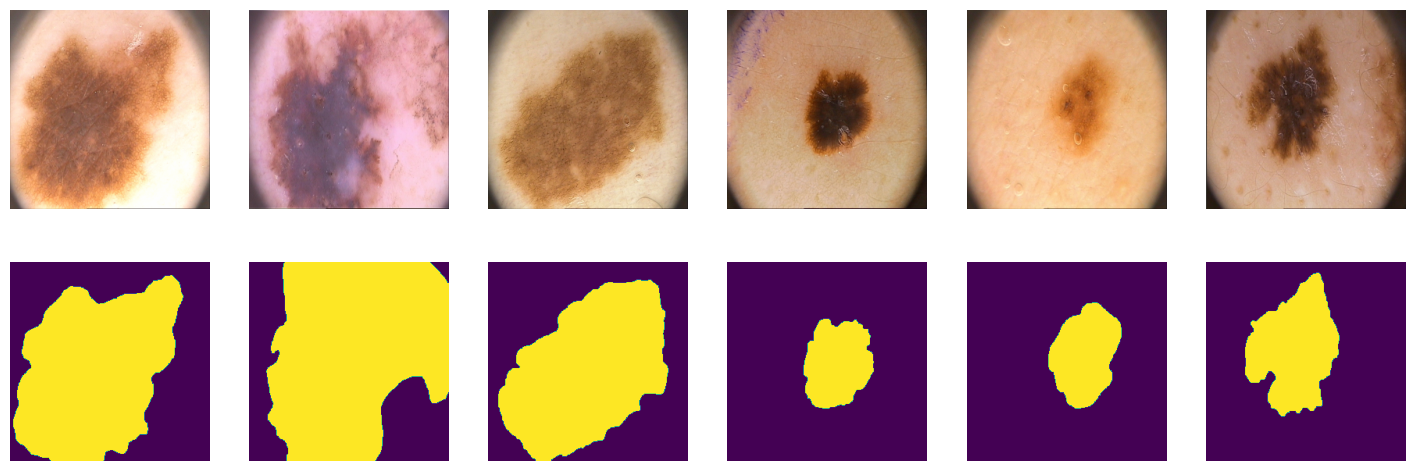

In [ ]:
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

In [ ]:
# 100/50/50 -  обучение, валидация, тест, соответственно

ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [ ]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
final_table = pd.DataFrame({'model':[],
                            'IoU': [],
                            'loss': [] })
final_table

Empty DataFrame
Columns: [model, IoU, loss]
Index: []

In [ ]:
# пробуем SegNet

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 =nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=64, out_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv1 =nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        self.pool2 =  nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.enc_conv3 =nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True))

        self.pool3 =   nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256,
                                                       kernel_size=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=256,
                                                       kernel_size=3, padding=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=512,
                                                       kernel_size=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))


        # decoder (upsampling)
        self.upsample0 =  nn.MaxUnpool2d(kernel_size=2, stride=2)
        self.dec_conv0 =  nn.Sequential(nn.Conv2d(in_channels=512, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        self.upsample1 =   nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_conv1 =  nn.Sequential(nn.Conv2d(in_channels=256, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        self.upsample2 =  nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_conv2 =  nn.Sequential(nn.onv2d(in_channels=128, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, ouCt_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        self.upsample3 =   nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.dec_conv3 =  nn.Sequential(nn.Conv2d(in_channels=64, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),
                                       nn.Conv2d(in_channels=64, out_channels=1,
                                                kernel_size=3, padding=1, stride=1))

    def forward(self, x):
        # encoder
        e0, ind0 = self.pool0(self.enc_conv0(x))
        e1, ind1 = self.pool1(self.enc_conv1(e0))
        e2, ind2 = self.pool2(self.enc_conv2(e1))
        e3, ind3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, ind3))
        d1 = self.dec_conv1(self.upsample1(d0, ind2))
        d2 = self.dec_conv2(self.upsample2(d1, ind1))
        d3 = self.dec_conv3(self.upsample3(d2, ind0))
        return d3

## Метрика


$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

    return thresholded  #

In [ ]:
# 1я сегментационная функция потерь - бинарная кросс-энтропия:

def bce_loss(y_real, y_pred):
    loss= (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred)))
    return torch.mean(loss)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = (model(X_batch.to(device)) > 0.5).int()
        scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

In [ ]:
max_epochs = 20

In [ ]:
# цикл обучения
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric):
    X_val, Y_val = next(iter(data_val))

    history = {'epoch': [],
               'train_loss': [],
               'val_loss': [],
               'train_metric': [],
               'val_metric': []}


    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_val_loss = 0
        avg_score = 0
        avg_val_score = 0

        model.train()  # train mode


        for ind, (X_batch, Y_batch) in enumerate(data_tr):

            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred)
            loss.backward()
            opt.step()

            avg_loss += loss / len(data_tr)
            avg_score += metric((Y_pred > 0.5).int(),
                                Y_batch).mean().item() / len(data_tr)
        toc = time()
        print('loss: %f' % avg_loss)

        # show intermediate results
        model.eval()  # testing mode
        Y_hat = model(X_val.to(device)).detach().cpu()

        for ind, (X_val_batch, Y_val_batch) in enumerate(data_val):

            X_val_batch = X_val_batch.to(device)
            Y_val_batch = Y_val_batch.to(device)

            Y_hat_batch = model(X_val_batch).detach()

            loss_val = loss_fn(Y_val_batch, Y_hat_batch)

            # calculate loss + score
            avg_val_loss += loss_val / len(data_val)
            avg_val_score += metric((Y_hat_batch > 0.5).int(),
                                    Y_val_batch.to(device)).mean().item() / len(data_val)

        history['epoch'].append(epoch)
        history['train_loss'].append(avg_loss.item())
        history['val_loss'].append(avg_val_loss.item())
        history['train_metric'].append(avg_score)
        history['val_metric'].append(avg_val_score)


        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, avg_loss))
        plt.show()
        del Y_hat
    return history

In [ ]:
# инференс
def predict(model, data):
    model.eval()  # testing mode
    Y_pred = [ X_batch for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
def figures(history):
    plt.figure(figsize=(10, 6))

    sns.lineplot(x='epoch', y='train_loss', data=history, label='train_loss')
    sns.lineplot(x='epoch', y='val_loss', data=history, label='val_loss')
    sns.lineplot(x='epoch', y='train_metric', data=history, label='train_score')
    sns.lineplot(x='epoch', y='val_metric', data=history, label='val_score')

    plt.grid()
    plt.legend()
    plt.ylabel('Loss/Metric')
    plt.title('Training History')
    plt.show()

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn")

def display_data(model, optimizer, loss, nn_name, loss_name):
    global final_table
    history=train(model, optimizer, loss,
                 max_epochs, data_tr, data_val, iou_pytorch)
    figures(history)
    iou_score=score_model(model, iou_pytorch, data_val)
    contemp_df= pd.DataFrame({'model': [nn_name], 'IoU': [iou_score], 'loss': [loss_name]})
    final_table = pd.concat([final_table, contemp_df], ignore_index=True)

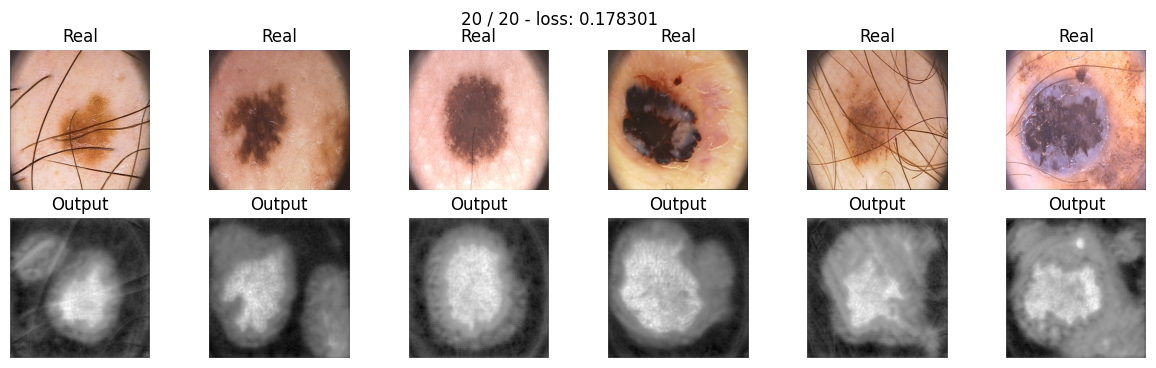

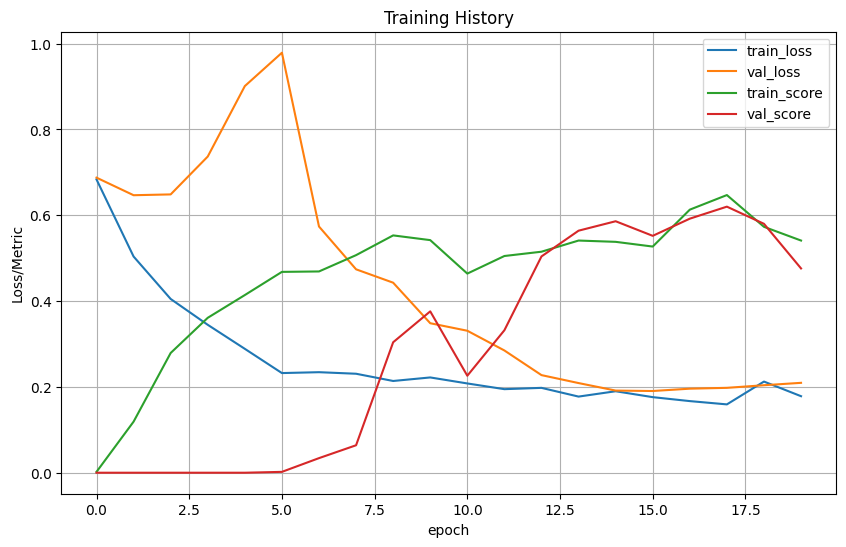

In [ ]:
model = SegNet().to(device)
optimizer = torch.optim.Adam(model.parameters())
d1= display_data(model, optimizer, bce_loss, 'SegNet', 'binary cross-entropy')


In [ ]:
torch.cuda.empty_cache()
# del history

In [ ]:
# дополнительная функция потерь - Dice coefficient
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = 2 * torch.sum(y_real * y_pred) + 1e-8
    den = torch.sum(y_real + y_pred) + 1e-8
    res = (1 - (num / den)).mean()
    return res

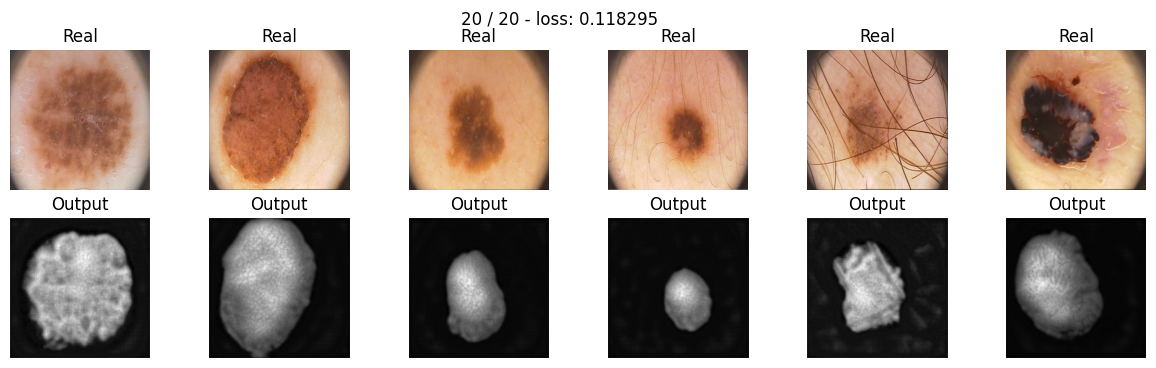

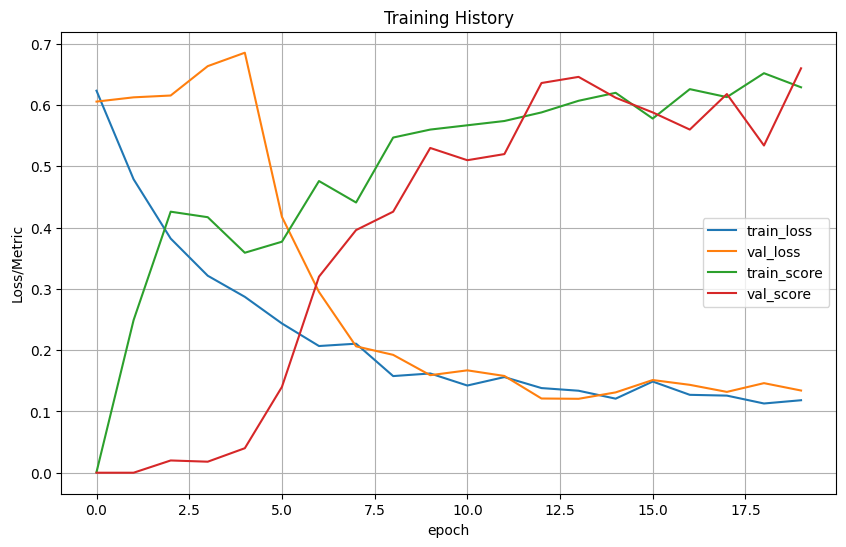

In [ ]:
model_dice = SegNet().to(device)
optimizer = torch.optim.Adam(model_dice.parameters())
d1= display_data(model_dice,
                  optimizer,
                  dice_loss,
                  'SegNet', 'DICE')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Дополнительная функция потерь - focal loss

def focal_loss(y_real, y_pred, eps = 1e-6, gamma = 2):
    s = torch.clamp(torch.sigmoid(y_pred), eps, 1 - eps)
    loss = -((1-s)**gamma*y_real*s.log() + s**gamma*(1-y_real)*(1-s).log())
    return loss.mean()

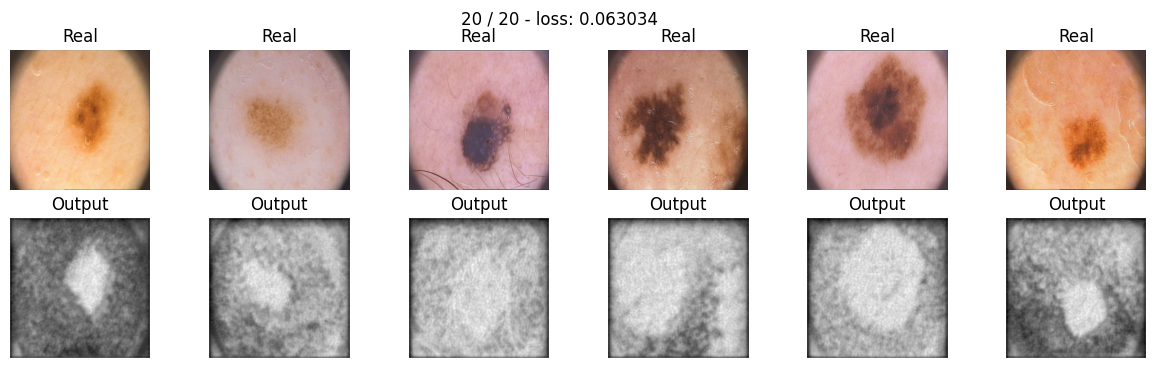

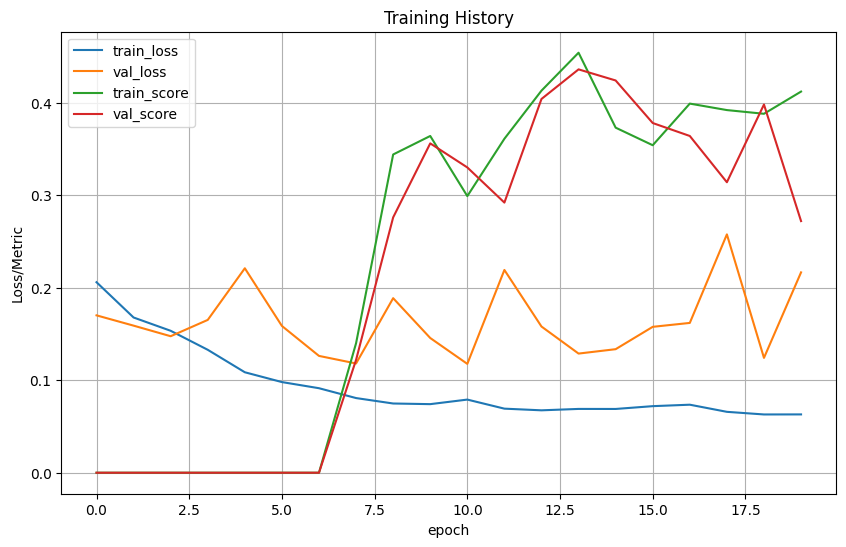

In [ ]:
model_focal = SegNet().to(device)
optimizer = torch.optim.Adam(model_focal.parameters())
d1= display_data(model_focal, optimizer, focal_loss, 'SegNet', 'focal loss')

In [ ]:
torch.cuda.empty_cache()

In [ ]:
# Дополнительная функция потерь - Тверский лосс

def tversky_loss(y_pred, y_real, alpha=0.5, beta=0.5):
    y_pred = torch.sigmoid(y_pred)
    t0 = torch.sum(y_pred * y_real)
    t1 =torch.sum((torch.ones_like(y_real, device=device) - y_real) * y_pred)
    t2 = torch.sum((torch.ones_like(y_pred, device=device) - y_pred) * y_real)

    return 1 - ((t0 + 1e-8) / (t0 + t1*alpha + t2*beta + 1e-8))

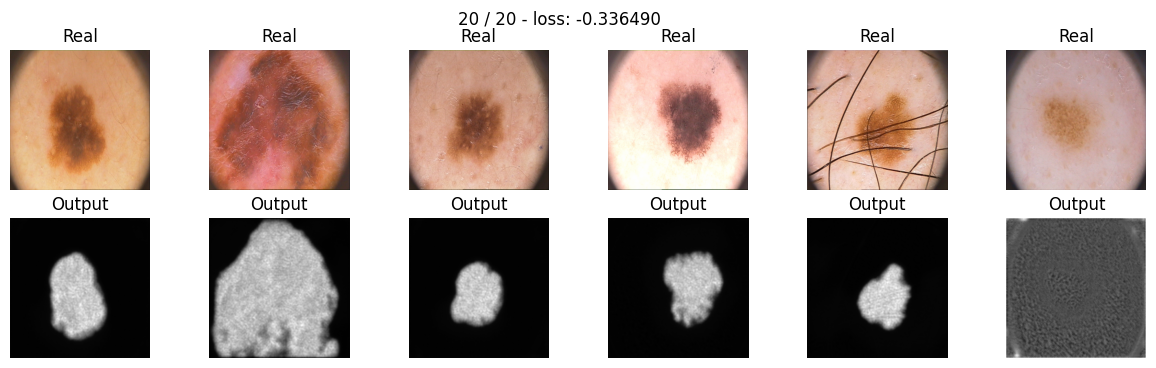

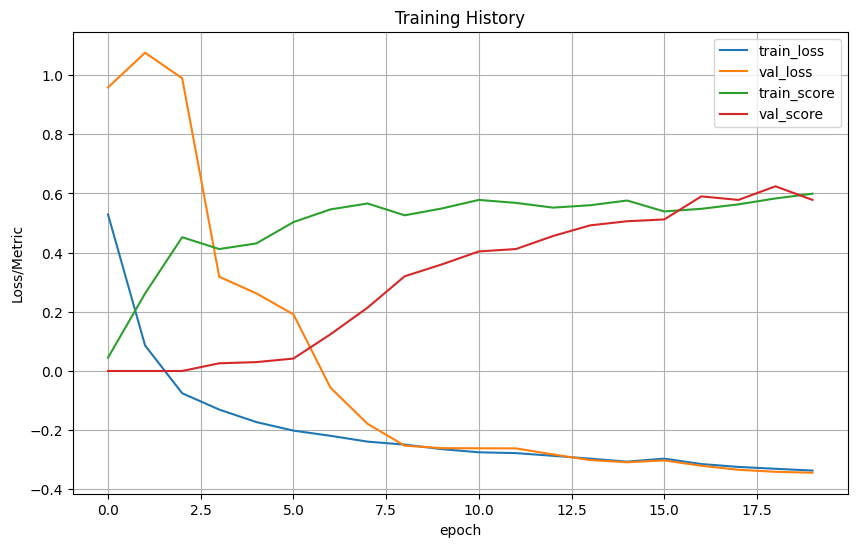

In [ ]:
model_tversky = SegNet().to(device)
optimizer = torch.optim.Adam(model_tversky.parameters())
d1= display_data(model_tversky, optimizer, tversky_loss, 'SegNet', 'tversky loss')

In [ ]:
final_table=final_table.copy()

torch.cuda.empty_cache()
del d1

In [ ]:
# def lovasz_hinge(logits, labels, per_image=True, ignore=None):
#     """
#     Binary Lovasz hinge loss
#       logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
#       labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
#       per_image: compute the loss per image instead of per batch
#       ignore: void class id
#     """
#     if per_image:
#         def treat_image(log_lab):
#             log, lab = log_lab
#             log, lab = tf.expand_dims(log, 0), tf.expand_dims(lab, 0)
#             log, lab = flatten_binary_scores(log, lab, ignore)
#             return lovasz_hinge_flat(log, lab)
#         losses = tf.map_fn(treat_image, (logits, labels), dtype=tf.float32)
#         loss = tf.reduce_mean(losses)
#     else:
#         loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
#     return loss

# def lovasz_softmax(y_pred, y_real):
#     inputs = F.sigmoid(y_pred)
#     Lovasz = lovasz_hinge(y_pred, y_real, per_image=False)
#     return Lovasz

In [ ]:
# model_lovasz = SegNet().to(device)
# optimizer = torch.optim.Adam(model_lovasz.parameters())
# df5= display_data(model_lovasz, optimizer, lovasz_softmax, 'SegNet', 'lovasz')

In [ ]:
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [ ]:
#  Модель - U-Net

class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=64, out_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        # 256 -> 128
        self.pool0 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        # 128 -> 64
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        # 64 -> 32
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True))

        # 32 -> 16
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256,
                                                       kernel_size=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=256,
                                                       kernel_size=3, padding=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=512,
                                                       kernel_size=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))

        # decoder (upsampling)

        # 16 -> 32
        self.upsample0 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        # 32 -> 64
        self.upsample1 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        # 64 -> 128
        self.upsample2 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, out_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        # 128 -> 256
        self.upsample3 = nn.Upsample(scale_factor=2, mode='nearest')

        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=64, out_channels=1,
                                                kernel_size=3, padding=1, stride=1))

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(p3)

        # decoder
        d0 =self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 =self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 =self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 =   self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))
        return d3

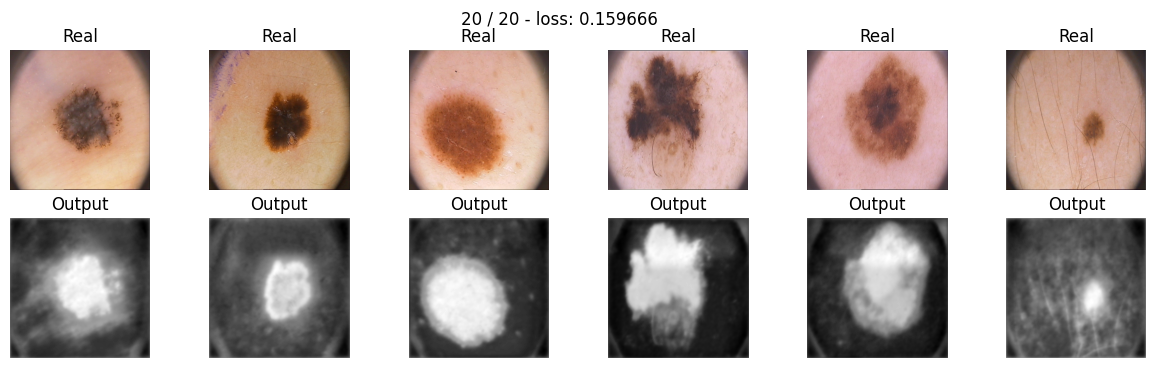

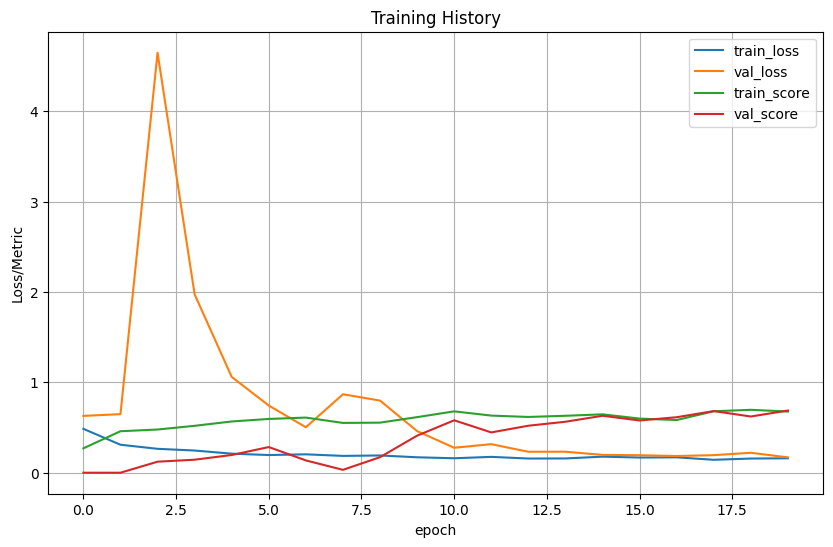

In [ ]:
model_bce = UNet().to(device)
optimizer = torch.optim.Adam(model_bce.parameters())
d1= display_data(model_bce, optimizer, bce_loss, 'UNet', 'binary cross-entropy')


In [ ]:
torch.cuda.empty_cache()

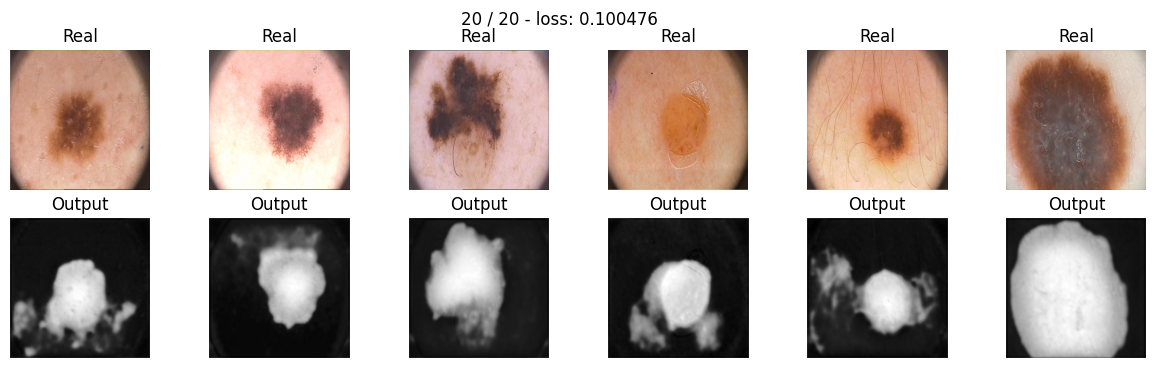

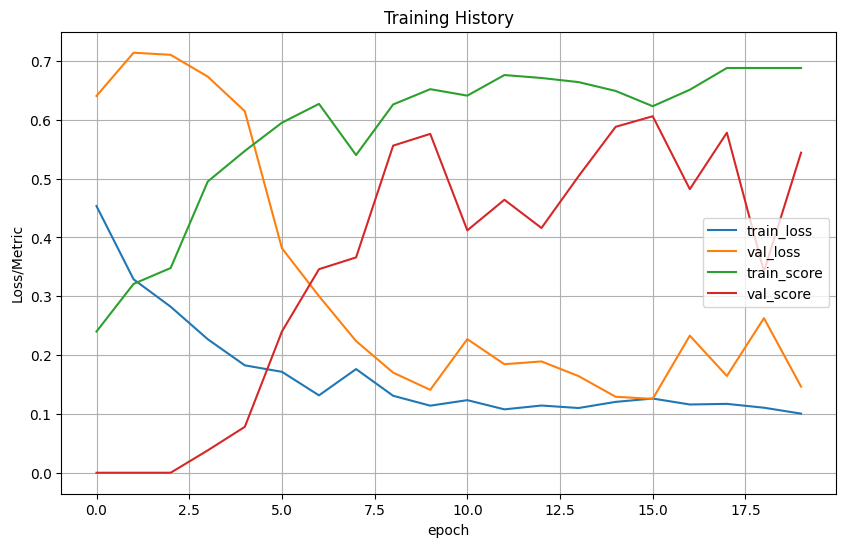

In [ ]:
model_dice = UNet().to(device)
optimizer = torch.optim.Adam(model_dice.parameters())
d1= display_data(model_dice,
                  optimizer,
                  dice_loss,
                  'UNet', 'DICE')

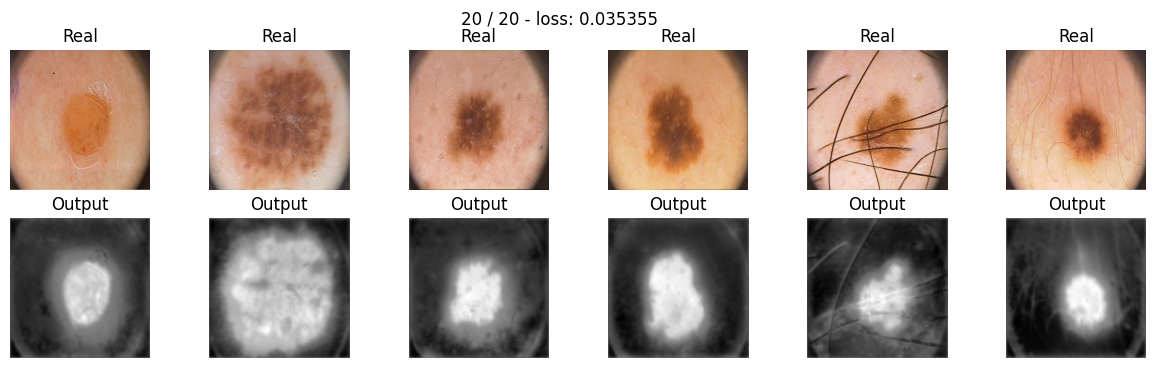

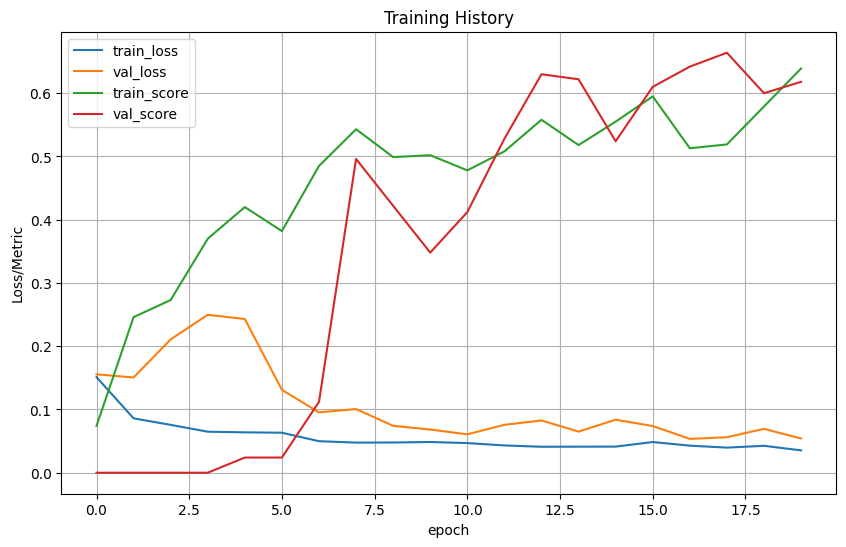

In [ ]:
model_focal =  UNet().to(device)
optimizer = torch.optim.Adam(model_focal.parameters())
d1= display_data(model_focal, optimizer, focal_loss, 'UNet', 'focal loss')

In [ ]:
torch.cuda.empty_cache()

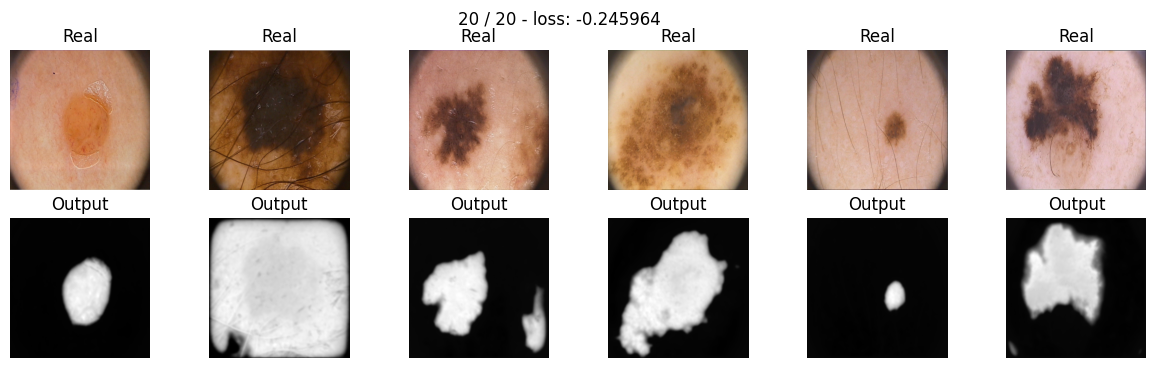

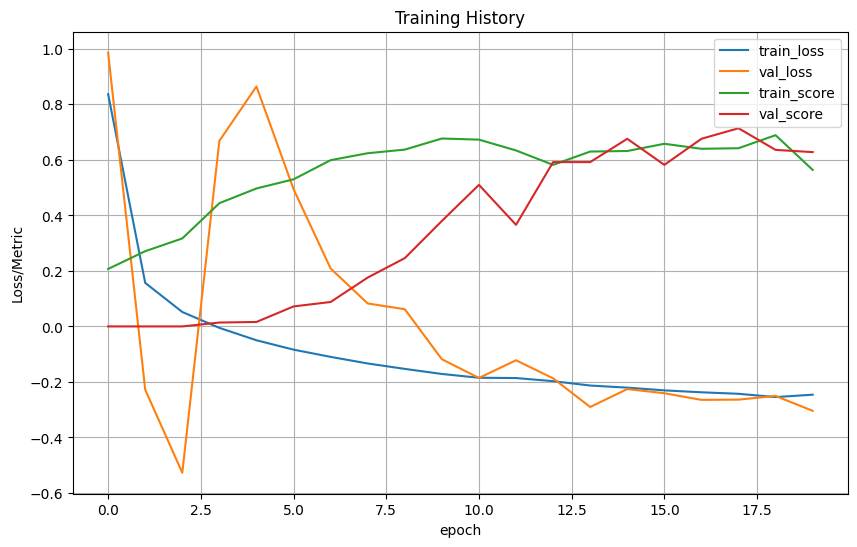

In [ ]:
model_tversky = UNet().to(device)
optimizer = torch.optim.Adam(model_tversky.parameters())
d1= display_data(model_tversky, optimizer, tversky_loss, 'UNet', 'tversky loss')

In [ ]:
torch.cuda.empty_cache()
del d1

Новая модель - изменили пулинг:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)


In [ ]:
# модификация UNet - изменили пулинг (изменили max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2)

class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        self.enc_conv0 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=64, out_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        # 256 -> 128
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64,
                               kernel_size=3, stride=2, padding=1)

        self.enc_conv1 = nn.Sequential(nn.Conv2d(in_channels=64, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        # 128 -> 64
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128,
                               kernel_size=3, stride=2, padding=1)

        self.enc_conv2 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        # 64 -> 32
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256,
                               kernel_size=3, stride=2, padding=1)

        self.enc_conv3 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True))

        # 32 -> 16
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512,
                               kernel_size=3, stride=2, padding=1)

        # bottleneck
        self.bottleneck_conv = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256,
                                                       kernel_size=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=256,
                                                       kernel_size=3, padding=1, stride=1),
                                             nn.BatchNorm2d(256),
                                             nn.ReLU(inplace=True),

                                             nn.Conv2d(in_channels=256, out_channels=512,
                                                       kernel_size=1),
                                             nn.BatchNorm2d(512),
                                             nn.ReLU(inplace=True))

        # decoder (upsampling)

        # 16 -> 32
        self.upsample0 = nn.ConvTranspose2d(512, 512, 3, stride=2, padding=1, output_padding=1)

        self.dec_conv0 = nn.Sequential(nn.Conv2d(in_channels=1024, out_channels=512,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=512,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=512),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=512, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True))

        # 32 -> 64
        self.upsample1 = nn.ConvTranspose2d(256, 256, 3, stride=2, padding=1, output_padding=1)

        self.dec_conv1 = nn.Sequential(nn.Conv2d(in_channels=512, out_channels=256,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=256,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=256),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=256, out_channels=128,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True))

        # 64 -> 128
        self.upsample2 = nn.ConvTranspose2d(128, 128, 3, stride=2, padding=1, output_padding=1)

        self.dec_conv2 = nn.Sequential(nn.Conv2d(in_channels=256, out_channels=128,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=128),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=128, out_channels=64,
                                                kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True))

        # 128 -> 256
        self.upsample3 = nn.ConvTranspose2d(64, 64, 3, stride=2, padding=1, output_padding=1)

        self.dec_conv3 = nn.Sequential(nn.Conv2d(in_channels=128, out_channels=64,
                                                 kernel_size=3, padding=1, stride=1),
                                       nn.BatchNorm2d(num_features=64),
                                       nn.ReLU(inplace=True),

                                       nn.Conv2d(in_channels=64, out_channels=1,
                                                kernel_size=3, padding=1, stride=1))

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        p0 = self.pool0(e0)
        e1 = self.enc_conv1(p0)
        p1 = self.pool1(e1)
        e2 = self.enc_conv2(p1)
        p2 = self.pool2(e2)
        e3 = self.enc_conv3(p2)
        p3 = self.pool3(e3)
        b = self.bottleneck_conv(p3)

        # decoder
        d0 = self.dec_conv0(torch.cat((self.upsample0(b), e3), dim=1))
        d1 = self.dec_conv1(torch.cat((self.upsample1(d0), e2), dim=1))
        d2 = self.dec_conv2(torch.cat((self.upsample2(d1), e1), dim=1))
        d3 = self.dec_conv3(torch.cat((self.upsample3(d2), e0), dim=1))
        return d3

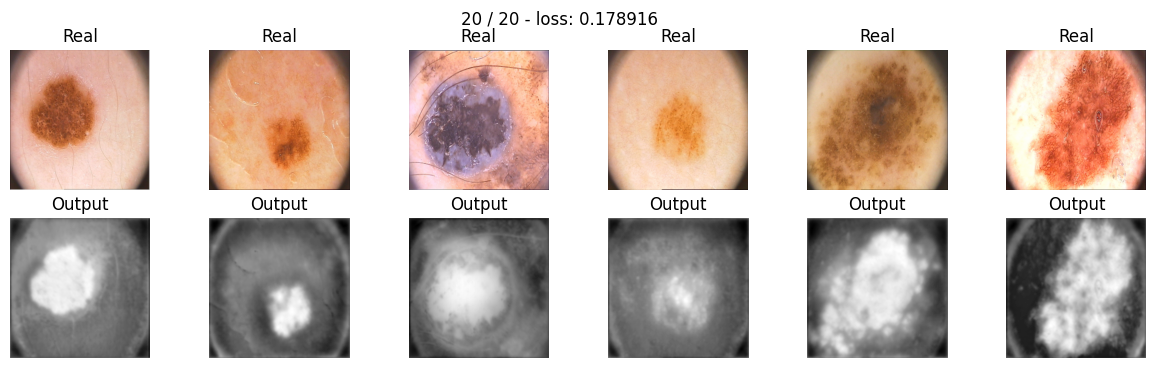

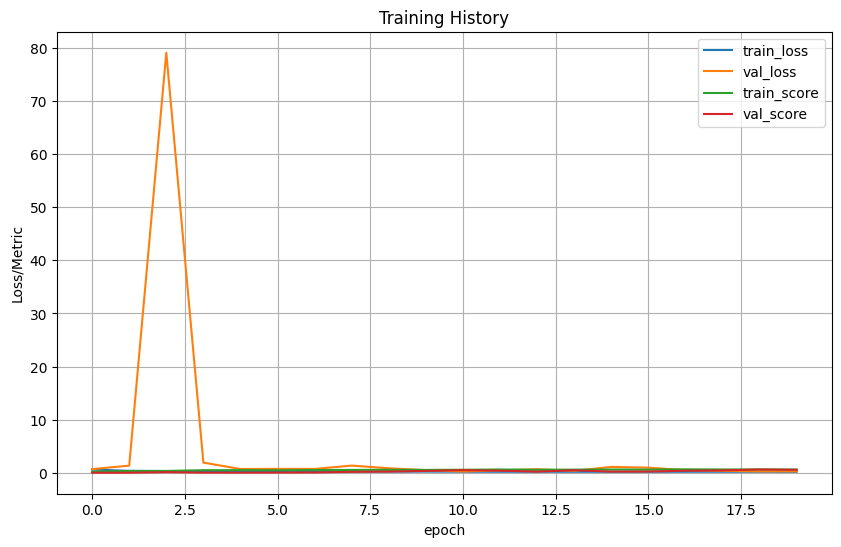

In [ ]:
model_bce = UNet2().to(device)
optimizer = torch.optim.Adam(model_bce.parameters())
d1= display_data(model_bce, optimizer, bce_loss, 'UNet2', 'binary cross-entropy')

In [ ]:
torch.cuda.empty_cache()

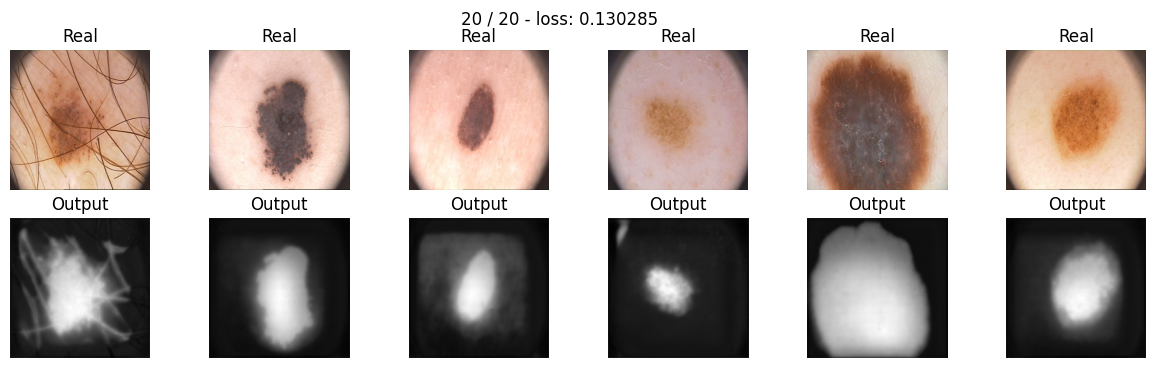

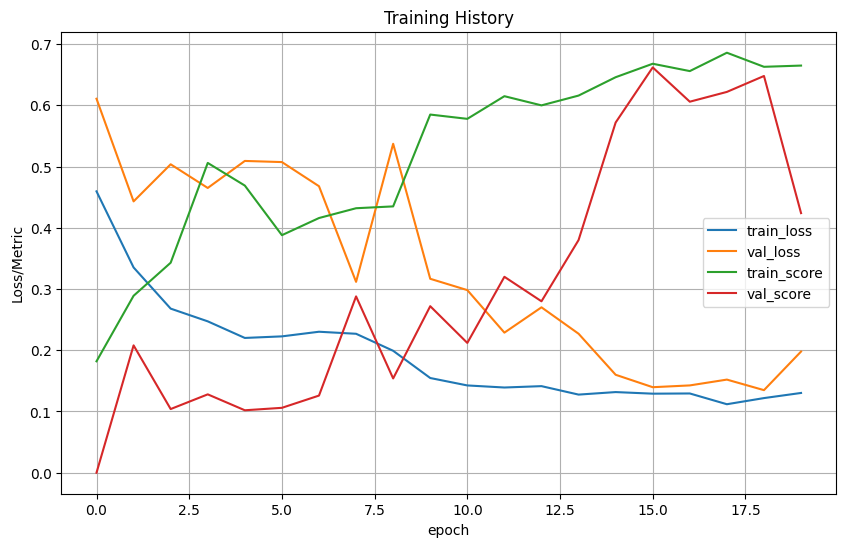

In [ ]:
model_dice =  UNet2().to(device)
optimizer = torch.optim.Adam(model_dice.parameters())
d1= display_data(model_dice,
                  optimizer,
                  dice_loss,
                  'UNet2', 'DICE')

In [ ]:
torch.cuda.empty_cache()

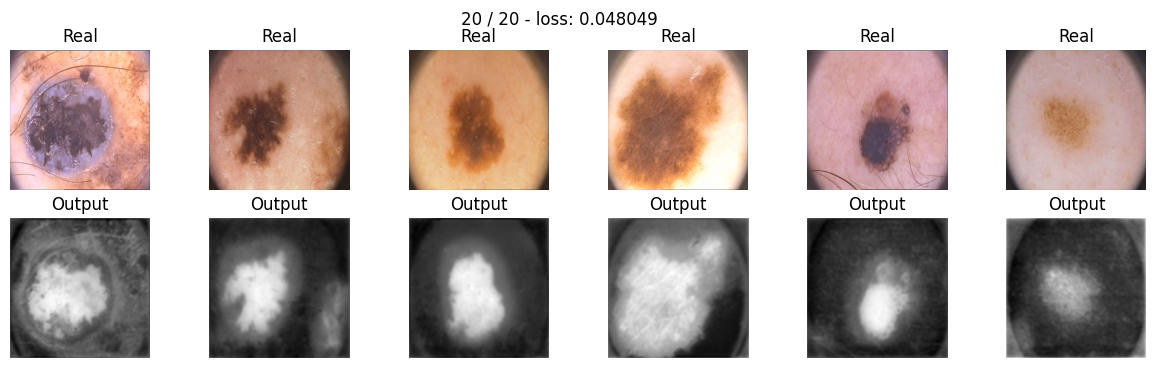

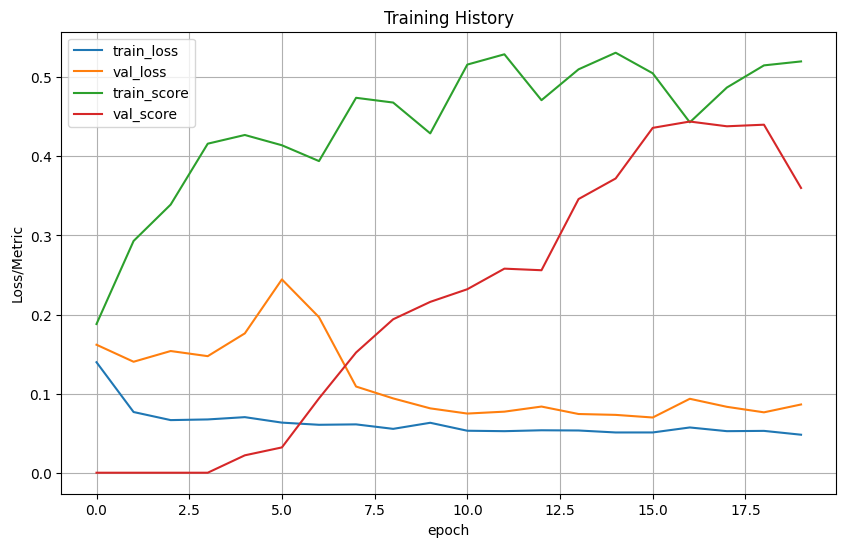

In [ ]:
model_focal =  UNet2().to(device)
optimizer = torch.optim.Adam(model_focal.parameters())
d1= display_data(model_focal, optimizer, focal_loss, 'UNet2', 'focal loss')

In [ ]:
torch.cuda.empty_cache()

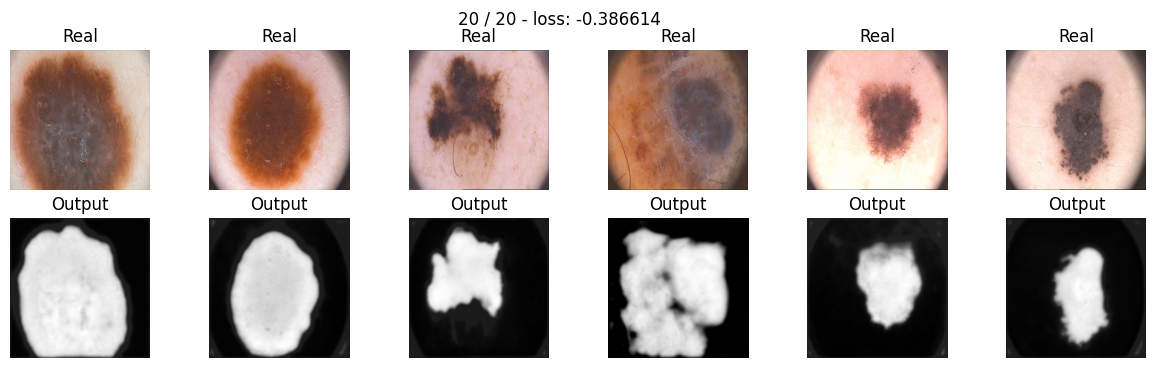

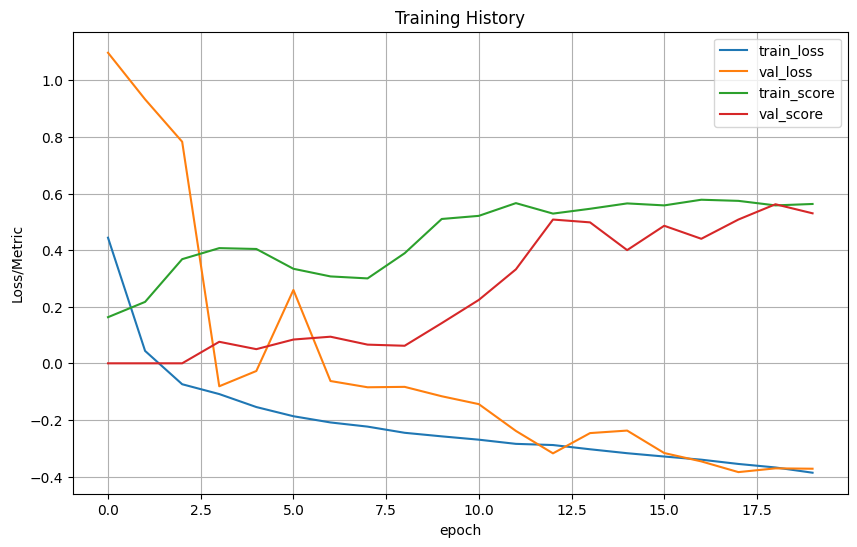

In [ ]:
model_tversky =  UNet2().to(device)
optimizer = torch.optim.Adam(model_tversky.parameters())
d1= display_data(model_tversky, optimizer, tversky_loss, 'UNet2', 'tversky loss')

In [ ]:
final_table.sort_values(by='IoU', ascending=False)

model    IoU                  loss
4     UNet  0.688  binary cross-entropy
1   SegNet  0.660                  DICE
7     UNet  0.628          tversky loss
6     UNet  0.618            focal loss
3   SegNet  0.578          tversky loss
5     UNet  0.544                  DICE
8    UNet2  0.540  binary cross-entropy
11   UNet2  0.530          tversky loss
0   SegNet  0.476  binary cross-entropy
9    UNet2  0.424                  DICE
10   UNet2  0.360            focal loss
2   SegNet  0.272            focal loss

In [ ]:
final_table.sort_values(by=['model','IoU'] , ascending=False)

model    IoU                  loss
8    UNet2  0.540  binary cross-entropy
11   UNet2  0.530          tversky loss
9    UNet2  0.424                  DICE
10   UNet2  0.360            focal loss
4     UNet  0.688  binary cross-entropy
7     UNet  0.628          tversky loss
6     UNet  0.618            focal loss
5     UNet  0.544                  DICE
1   SegNet  0.660                  DICE
3   SegNet  0.578          tversky loss
0   SegNet  0.476  binary cross-entropy
2   SegNet  0.272            focal loss

Графики изменения loss и метрики IoU в процессе обучения изображены на графиках в ноутбуке

- Архитектура UNet за счет skip-connection дает лучшие результаты по сравнению с Segnet,а также UNet2 (почему-то)-обучение более стабильное.
- В парном сочетании модель-функция потерь функции binary cross-entropy,DICE, focal loss, tversky loss ведут себя по-разному. binary cross-entropy лучше всего на UNet, UNet2. На SegNet лучше всего dice. на всех моделях второе место занимает tversky loss
- Переобучение замечено не было- valid score повышается в процессе обучения.
- Лучший результат IoU=0.688 показала модель UNet с binary cross-entropy. Модель отличается в среднем большей стабильностью, но имеет огромный выпад на одной эпохе в начале обучения.
- Для лучшего обучения можно увеличивать количество эпох и размеры батчей.
